## Image classifier for the SVHN dataset


In [ ]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat

In [ ]:
# Run this cell to connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the dataset from your Drive folder
train = loadmat('/content/gdrive/MyDrive/Colab Notebooks/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/Colab Notebooks/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset




---



* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.

In [ ]:
# extract X and y from train and test dictionaries
X_train,y_train=train["X"],train["y"]
X_test,y_test=test["X"],test["y"]
# convert X into (n_samples,nx,ny,nc)
X_train = np.transpose(X_train,(3 ,0 ,1,2))
X_test = np.transpose(X_test,(3 ,0 ,1,2))
# normalize images
X_train=X_train/255.0
X_test=X_test/255.0
# y's contain a "10" label when zeros are
# shown, convert the label to "0" instead
y_train[y_train==10]=0
y_test[y_test==10]=0
# convert labels to one-hot encoder
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

* Select a random sample of images and corresponding labels from the 
dataset (at least 10), and display them in a figure.

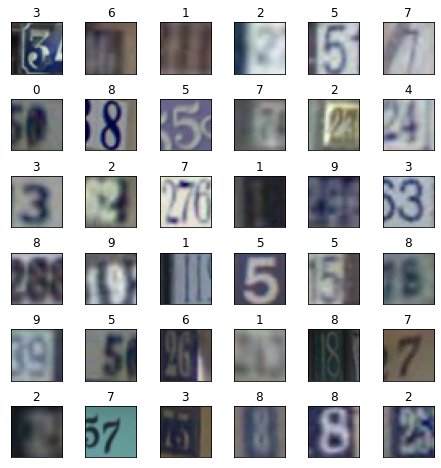

In [ ]:
import matplotlib.pyplot as plt
# select 36 random samples of images
idx = np.random.randint(0, X_train.shape[0], size=36)
# plot them on a 6 x 6 grid
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8,8),)
for ii, ax in zip(idx, axes.flatten()):
  ax.imshow(X_train[ii], aspect='equal')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_title(f"{y_train[ii][0]}")
plt.subplots_adjust(wspace=0, hspace=0.5)

* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1.

In [ ]:
# convert X_train and y_train to grayscale
X_train_gs=np.average(X_train,axis=-1)[:,:,:,np.newaxis]
X_test_gs=np.average(X_test,axis=-1)[:,:,:,np.newaxis]

* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

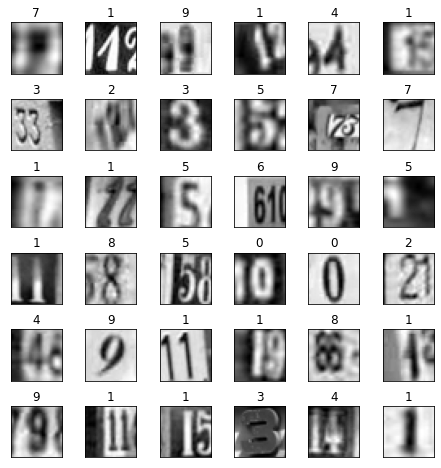

In [ ]:
import matplotlib.pyplot as plt
# select 36 random samples of images
idx = np.random.randint(0, X_train_gs.shape[0], size=36)
# plot them on a 6 x 6 grid
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8,8),)
for ii, ax in zip(idx, axes.flatten()):
  ax.imshow(X_train_gs[ii,:,:,0], aspect='equal',cmap=plt.get_cmap('gray'))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_title(f"{y_train[ii][0]}")
plt.subplots_adjust(wspace=0, hspace=0.5)

## 2. MLP neural network classifier

In [ ]:
# run some imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import pandas as pd

In [ ]:
# define model building function
def build_mlp(input_shape,n_neurons):
  model=Sequential([
      Flatten(input_shape=input_shape,name="flatten"),
      Dense(n_neurons,activation="relu",name="dense_1"),
      Dense(n_neurons,activation="relu",name="dense_2"),
      Dense(n_neurons,activation="relu",name="dense_3"),
      Dense(10,activation="softmax",name="softmax"), 
  ])
  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model
  
# define function to evaluate model on test set
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('test accuracy: {acc:0.3f}'.format(acc=test_acc))



*   Model with 3 hidden layers and 64 neurons



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                65600     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 softmax (Dense)             (None, 10)                650       
                                                                 
Total params: 74,570
Trainable params: 74,570
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30

Epoch 1: val_loss improved from inf to 1

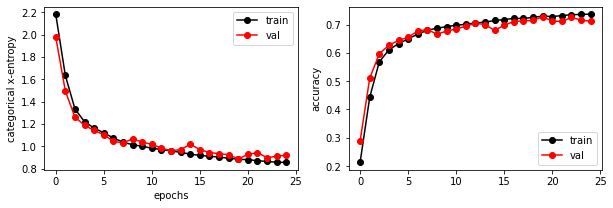

In [ ]:
# fix seeds
np.random.seed(123)
tf.random.set_seed(123)
# invoke model
model=build_mlp(X_train_gs[0].shape,n_neurons=64)
# show model summary
model.summary()
# create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path="model_mlp_64_neurons/best_mlp"
checkpoint_best=ModelCheckpoint(filepath=checkpoint_best_path,
                                save_weights_only=True,
                                monitor="val_loss",
                                save_best_only=True,
                                verbose=1)
# create early stopping callback
es=EarlyStopping(monitor="val_loss",mode="min",patience=5)
# create lr_plateau
reduceLRplat = ReduceLROnPlateau(monitor="val_loss",patience=5)
# define list of callbacks
callbacks=[checkpoint_best,es,reduceLRplat]
# fit model
history = model.fit(X_train_gs,y_train_cat,validation_split=0.2 , verbose = 2 ,
                    epochs=30 ,batch_size=128, callbacks=callbacks)
# save training to dataframe
df=pd.DataFrame(history.history)
# visualize learning
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(df["loss"],'ko-',label="train")
plt.plot(df["val_loss"],'ro-',label="val")
plt.xlabel("epochs")
plt.ylabel("categorical x-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df["accuracy"],'ko-',label="train")
plt.plot(df["val_accuracy"],'ro-',label="val")
plt.ylabel("accuracy")
plt.legend()

Evaluate best_weigths on "test set"

In [ ]:
# create new model
model=build_mlp(X_train_gs[0].shape,n_neurons=64)
# load best weights
model.load_weights(tf.train.latest_checkpoint("model_mlp_64_neurons"))
# evaluate model on test set
get_test_accuracy(model, X_test_gs, y_test_cat)

test accuracy: 0.699


* Model with 3 hidden layers and 128 neurons

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 softmax (Dense)             (None, 10)                1290      
                                                                 
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30

Epoch 1: val_loss improved from inf 

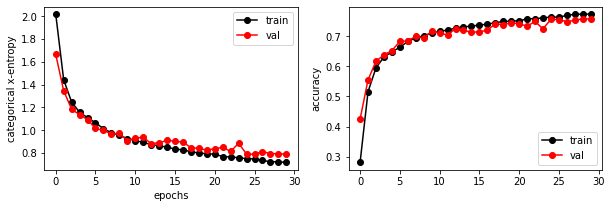

In [ ]:
# fix seeds
np.random.seed(123)
tf.random.set_seed(123)
# invoke model
model=build_mlp(X_train_gs[0].shape,n_neurons=128)
# show model summary
model.summary()
# create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path="model_mlp_128_neurons/best_mlp"
checkpoint_best=ModelCheckpoint(filepath=checkpoint_best_path,
                                save_weights_only=True,
                                monitor="val_loss",
                                save_best_only=True,
                                verbose=1)
# create early stopping callback
es=EarlyStopping(monitor="val_loss",mode="min",patience=5)
# create lr_plateau
reduceLRplat = ReduceLROnPlateau(monitor="val_loss",patience=5)
# define list of callbacks
callbacks=[checkpoint_best,es,reduceLRplat]
# fit model
history = model.fit(X_train_gs,y_train_cat,validation_split=0.2 , verbose = 2 ,
                    epochs=30 ,batch_size=128, callbacks=callbacks)
# save training to dataframe
df=pd.DataFrame(history.history)
# visualize learning
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(df["loss"],'ko-',label="train")
plt.plot(df["val_loss"],'ro-',label="val")
plt.xlabel("epochs")
plt.ylabel("categorical x-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df["accuracy"],'ko-',label="train")
plt.plot(df["val_accuracy"],'ro-',label="val")
plt.ylabel("accuracy")
plt.legend()

In this example featuring 128 neurons, we can see the early signs of overfitting.

Evaluate best_weigths on "test set"

In [ ]:
# create new model
model=build_mlp(X_train_gs[0].shape,n_neurons=128)
# load best weights
model.load_weights(tf.train.latest_checkpoint("model_mlp_128_neurons"))
# evaluate model on test set
get_test_accuracy(model, X_test_gs, y_test_cat)

test accuracy: 0.736


* Model with 3 hidden layers and 256 neurons

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 softmax (Dense)             (None, 10)                2570      
                                                                 
Total params: 396,554
Trainable params: 396,554
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30

Epoch 1: val_loss improved from inf 

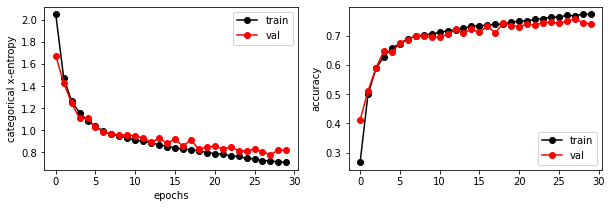

In [ ]:
# fix seeds  
np.random.seed(123)
tf.random.set_seed(123)
# invoke model
model=build_mlp(X_train_gs[0].shape,n_neurons=256)
# show model summary
model.summary()
# create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path="model_mlp_256_neurons/best_mlp"
checkpoint_best=ModelCheckpoint(filepath=checkpoint_best_path,
                                save_weights_only=True,
                                monitor="val_loss",
                                save_best_only=True,
                                verbose=1)
# create early stopping callback
es=EarlyStopping(monitor="val_loss",mode="min",patience=5)
# create lr_plateau
reduceLRplat = ReduceLROnPlateau(monitor="val_loss",patience=5)
# define list of callbacks
callbacks=[checkpoint_best,es,reduceLRplat]
# fit model
history = model.fit(X_train_gs,y_train_cat,validation_split=0.2 , verbose = 2 ,
                    epochs=30 ,batch_size=128, callbacks=callbacks)
# save training to dataframe
df=pd.DataFrame(history.history)
# visualize learning
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(df["loss"],'ko-',label="train")
plt.plot(df["val_loss"],'ro-',label="val")
plt.xlabel("epochs")
plt.ylabel("categorical x-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df["accuracy"],'ko-',label="train")
plt.plot(df["val_accuracy"],'ro-',label="val")
plt.ylabel("accuracy")
plt.legend()

We can see overfitting more clearly in this example with 256 neurons.
So we´d better revert back to previous example with 128 neurons.

In [ ]:
# create new model
model=build_mlp(X_train_gs[0].shape,n_neurons=256)
# load best weights
model.load_weights(tf.train.latest_checkpoint("model_mlp_256_neurons"))
# evaluate model on test set
get_test_accuracy(model, X_test_gs, y_test_cat)

test accuracy: 0.730


**We´re keeping the example with 128 neurons (165,514 parameters) and visualize the weights in each layer.**

In [ ]:
# create new model
model=build_mlp(X_train_gs[0].shape,n_neurons=128)
# load best weights
model.load_weights(tf.train.latest_checkpoint("model_mlp_128_neurons"))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 softmax (Dense)             (None, 10)                1290      
                                                                 
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


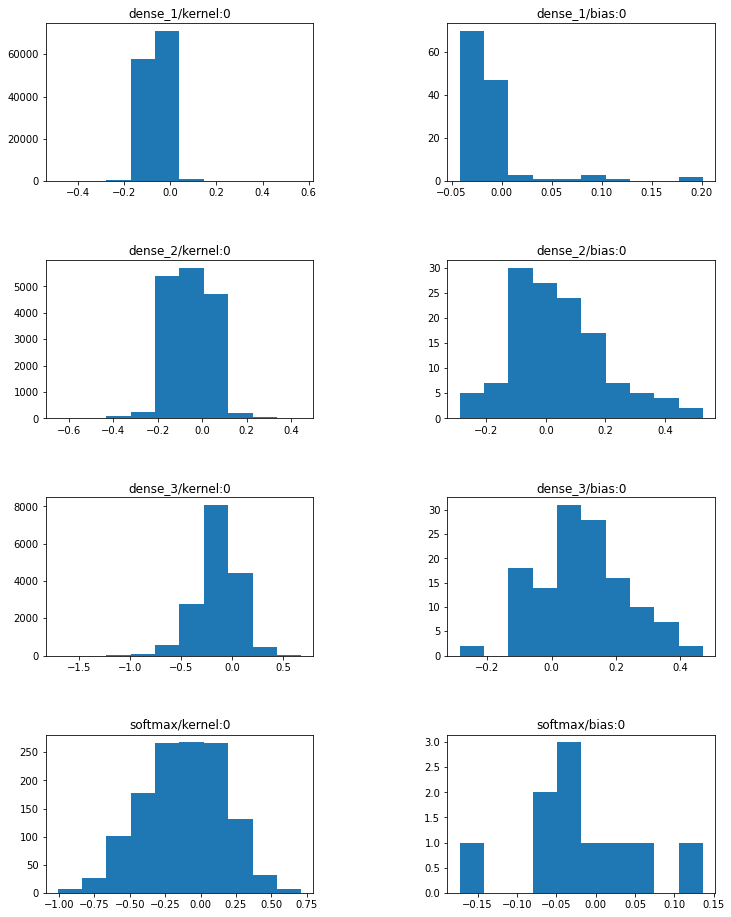

In [ ]:
# let´s visualize weights in each layer
fig, axes = plt.subplots(4, 2, figsize=(12,16))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# Filter out layers, that don't have any weights
weight_layers = [layer for layer in model.layers if len(layer.weights) > 0]
for i, layer in enumerate(weight_layers):
  for j in [0, 1]:
      axes[i, j].hist(layer.weights[j].numpy().flatten(), align='left')
      axes[i, j].set_title(layer.weights[j].name)



---



## 3. CNN neural network classifier


In [ ]:
# define model building function
def build_cnn(input_shape,n_filters,d_out,n_neurons):
  model=Sequential([
      Conv2D(filters=n_filters,kernel_size=3,activation="relu",input_shape=input_shape,name="conv_1"),
      BatchNormalization(),
      MaxPooling2D((2,2)),
      Dropout(d_out),
      Conv2D(filters=n_filters/2,kernel_size=3,activation="relu",name="conv_2"),
      BatchNormalization(),
      MaxPooling2D((2,2)),
      Dropout(d_out),
      Flatten(),
      Dense(n_neurons,activation="relu",name="dense_1"),
      Dense(n_neurons/2,activation="relu",name="dense_2"),
      Dense(10,activation="softmax",name="softmax"), 
  ])
  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  return model




*   We first evaluate a model with 16 filters and 64 neurons.



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 16)        0         
                                                                 
 conv_2 (Conv2D)             (None, 13, 13, 8)         1160      
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 8)       

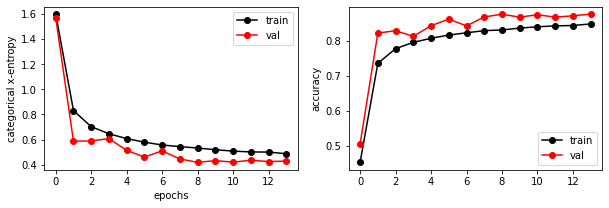

In [ ]:
# fix seeds  
np.random.seed(123)
tf.random.set_seed(123)
# invoke model
model=build_cnn(X_train_gs[0].shape,n_filters=16,d_out=0.3,n_neurons=64)
# show model summary
model.summary()
# create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path="model_cnn_16_filters/best_cnn"
checkpoint_best=ModelCheckpoint(filepath=checkpoint_best_path,
                                save_weights_only=True,
                                monitor="val_loss",
                                save_best_only=True,
                                verbose=1)
# create early stopping callback
es=EarlyStopping(monitor="val_loss",mode="min",patience=5)
# create lr_plateau
reduceLRplat = ReduceLROnPlateau(monitor="val_loss",patience=5)
# define list of callbacks
callbacks=[checkpoint_best,es,reduceLRplat]
# fit model
history = model.fit(X_train_gs,y_train_cat,validation_split=0.2 , verbose = 2 ,
                    epochs=30 ,batch_size=128, callbacks=callbacks)
# save training to dataframe
df=pd.DataFrame(history.history)
# visualize learning
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(df["loss"],'ko-',label="train")
plt.plot(df["val_loss"],'ro-',label="val")
plt.xlabel("epochs")
plt.ylabel("categorical x-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df["accuracy"],'ko-',label="train")
plt.plot(df["val_accuracy"],'ro-',label="val")
plt.ylabel("accuracy")
plt.legend()

This is very weird: "val_loss" less than "train_loss". A quick search suggests this may be due to drop_out layers [link here](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error) and not enough capacity. So i´ll increase the network capacity by adding more filters.


In [ ]:
# create new model
model=build_cnn(X_train_gs[0].shape,n_filters=16,d_out=0.3,n_neurons=64)
# load best weights
model.load_weights(tf.train.latest_checkpoint("model_cnn_16_filters"))
# evaluate model on test set
get_test_accuracy(model, X_test_gs, y_test_cat)

test accuracy: 0.859


* I´ll try 32 filters and 64 neurons.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 13, 13, 16)        4624      
                                                                 
 batch_normalization_5 (Batc  (None, 13, 13, 16)      

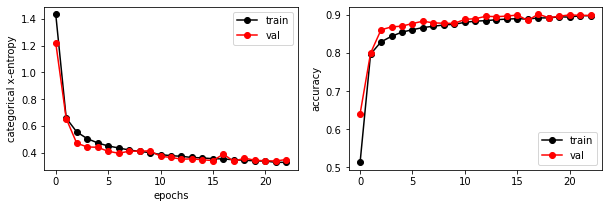

In [ ]:
# fix seeds  
np.random.seed(123)
tf.random.set_seed(123)
# invoke model
model=build_cnn(X_train_gs[0].shape,n_filters=32,d_out=0.3,n_neurons=64)
# show model summary
model.summary()
# create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path="model_cnn_32_filters/best_cnn"
checkpoint_best=ModelCheckpoint(filepath=checkpoint_best_path,
                                save_weights_only=True,
                                monitor="val_loss",
                                save_best_only=True,
                                verbose=1)
# create early stopping callback
es=EarlyStopping(monitor="val_loss",mode="min",patience=5)
# create lr_plateau
reduceLRplat = ReduceLROnPlateau(monitor="val_loss",patience=5)
# define list of callbacks
callbacks=[checkpoint_best,es,reduceLRplat]
# fit model
history = model.fit(X_train_gs,y_train_cat,validation_split=0.2 , verbose = 2 ,
                    epochs=30 ,batch_size=128, callbacks=callbacks)
# save training to dataframe
df=pd.DataFrame(history.history)
# visualize learning
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(df["loss"],'ko-',label="train")
plt.plot(df["val_loss"],'ro-',label="val")
plt.xlabel("epochs")
plt.ylabel("categorical x-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df["accuracy"],'ko-',label="train")
plt.plot(df["val_accuracy"],'ro-',label="val")
plt.ylabel("accuracy")
plt.legend()

In [ ]:
# create new model
model=build_cnn(X_train_gs[0].shape,n_filters=32,d_out=0.3,n_neurons=64)
# load best weights
model.load_weights(tf.train.latest_checkpoint("model_cnn_32_filters"))
# evaluate model on test set
get_test_accuracy(model, X_test_gs, y_test_cat)

test accuracy: 0.888


This one looks better and the weird behavior in the learning curves is gone. It seems like the combination of drop_out and low capacity might have been the culprit.

* I´ll now use 64 filters and 64 neurons. Maybe it´ll show some early signs of overfitting.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 13, 13, 32)        18464     
                                                                 
 batch_normalization_9 (Batc  (None, 13, 13, 32)     

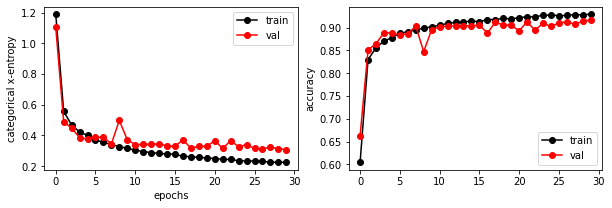

In [ ]:
# fix seeds  
np.random.seed(123)
tf.random.set_seed(123)
# invoke model
model=build_cnn(X_train_gs[0].shape,n_filters=64,d_out=0.3,n_neurons=64)
# show model summary
model.summary()
# create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_best_path="model_cnn_64_filters/best_cnn"
checkpoint_best=ModelCheckpoint(filepath=checkpoint_best_path,
                                save_weights_only=True,
                                monitor="val_loss",
                                save_best_only=True,
                                verbose=1)
# create early stopping callback
es=EarlyStopping(monitor="val_loss",mode="min",patience=5)
# create lr_plateau
reduceLRplat = ReduceLROnPlateau(monitor="val_loss",patience=5)
# define list of callbacks
callbacks=[checkpoint_best,es,reduceLRplat]
# fit model
history = model.fit(X_train_gs,y_train_cat,validation_split=0.2 , verbose = 2 ,
                    epochs=30 ,batch_size=128, callbacks=callbacks)
# save training to dataframe
df=pd.DataFrame(history.history)
# visualize learning
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(df["loss"],'ko-',label="train")
plt.plot(df["val_loss"],'ro-',label="val")
plt.xlabel("epochs")
plt.ylabel("categorical x-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(df["accuracy"],'ko-',label="train")
plt.plot(df["val_accuracy"],'ro-',label="val")
plt.ylabel("accuracy")
plt.legend()

In [ ]:
# create new model
model=build_cnn(X_train_gs[0].shape,n_filters=64,d_out=0.3,n_neurons=64)
# load best weights
model.load_weights(tf.train.latest_checkpoint("model_cnn_64_filters"))
# evaluate model on test set
get_test_accuracy(model, X_test_gs, y_test_cat)

test accuracy: 0.905


**I´ll stick with this network from now on....**

## 4. Get model predictions


In [ ]:
# create new mmlp
mlp=build_mlp(X_train_gs[0].shape,n_neurons=128)
# load best weights
mlp.load_weights(tf.train.latest_checkpoint("model_mlp_128_neurons"))
# create new cnn
cnn=build_cnn(X_train_gs[0].shape,n_filters=64,d_out=0.3,n_neurons=64)
# load best weights
cnn.load_weights(tf.train.latest_checkpoint("model_cnn_64_filters"))

In [ ]:
# evaluate mlp on test set
get_test_accuracy(mlp, X_test_gs, y_test_cat)

test accuracy: 0.736


In [ ]:
# evaluate cnn on test set
get_test_accuracy(cnn, X_test_gs, y_test_cat)

test accuracy: 0.905


# **CNN Results**

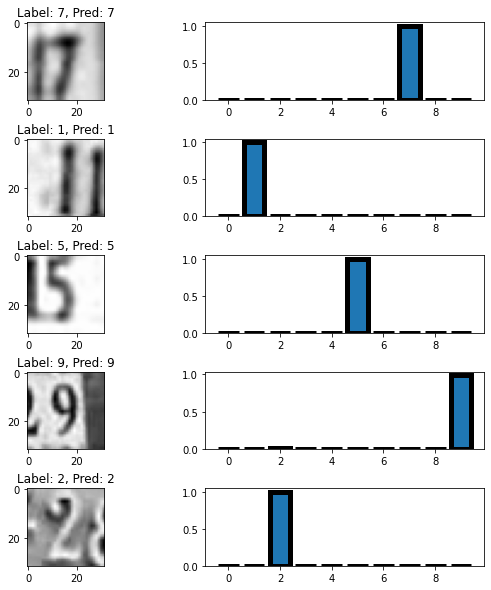

In [ ]:
# select 5 random samples of images
idx = np.random.randint(0, X_test.shape[0], size=5)
fig_idx=1
plt.figure(figsize=(10,10))
for i in range(5):
  cnn_pred=cnn.predict(X_test_gs[idx[i]][np.newaxis,...])
  plt.subplot(5,2,fig_idx+i)
  plt.imshow(X_test_gs[idx[i]][:,:,0], aspect='equal',cmap=plt.get_cmap('gray'))
  plt.title(f"Label: {y_test[idx[i]][0]}, Pred: {np.argmax(cnn_pred)}")
  plt.subplot(5,2,fig_idx+i+1)
  plt.bar(np.arange(0,10),np.transpose(cnn_pred)[:,0],linewidth=5,edgecolor="k")
  fig_idx=fig_idx+1
plt.subplots_adjust(wspace=0, hspace=0.5)  

# **MLP results**

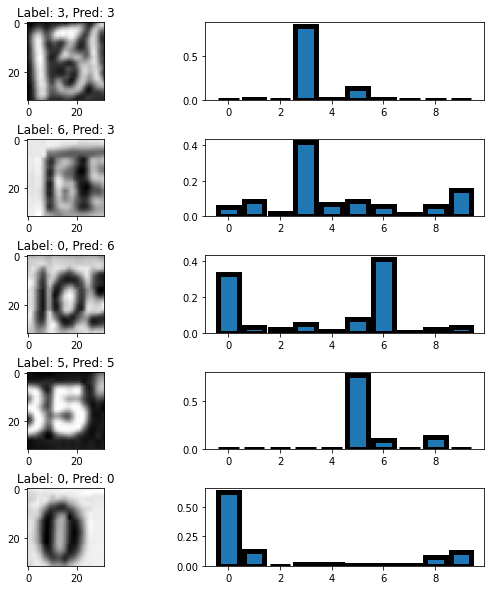

In [ ]:
# select 5 random samples of images
idx = np.random.randint(0, X_test.shape[0], size=5)
fig_idx=1
plt.figure(figsize=(10,10))
for i in range(5):
  cnn_pred=mlp.predict(X_test_gs[idx[i]][np.newaxis,...])
  plt.subplot(5,2,fig_idx+i)
  plt.imshow(X_test_gs[idx[i]][:,:,0], aspect='equal',cmap=plt.get_cmap('gray'))
  plt.title(f"Label: {y_test[idx[i]][0]}, Pred: {np.argmax(cnn_pred)}")
  plt.subplot(5,2,fig_idx+i+1)
  plt.bar(np.arange(0,10),np.transpose(cnn_pred)[:,0],linewidth=5,edgecolor="k")
  fig_idx=fig_idx+1
plt.subplots_adjust(wspace=0, hspace=0.5)  

In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb